In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm

from tqdm.notebook import tqdm

import numpy as np

from sklearn.decomposition import PCA

from neurodsp.sim import sim_powerlaw, sim_oscillation
from neurodsp.spectral import compute_spectrum

from timescales.autoreg.fit import simulate_ar

from eigvec.spectral import compute_eigenspectrum
from eigvec.circulant import sim_circulant, compute_kappa

## 1. Introduction: PCA & SVD

- Matrices of signals, $\mathbf{X}$, where columns are trials or electrodes.
- PCA is the eigendecomposition of the covariance matrix: $\text{cov}(\mathbf{X}) = \mathbf{Q} \mathbf{\Lambda} \mathbf{Q}^{-1}$.
- SVD is: $\mathbf{X} = \mathbf{U} \mathbf{S} \mathbf{V}^{\top}$, where $\mathbf{V} = \mathbf{Q}$ and $\mathbf{S}^2 = \mathbf{\Lambda}$.

In [2]:
def simulate(sim):
    # Simulate
    n = 2_000
    X = np.zeros((n, 2000))
    for i in range(n):
        np.random.seed(i)
        sig = sim()
        X[i] = (sig-sig.mean())/sig.std()
        
    cov = np.cov(X.T)
    
    return X, cov

def plot_cov(cov, ax):   
    # Plot covariance matrix
    # norm = mcolors.Normalize(vmin=0, vmax=1)
    im = ax.imshow(cov)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax)

def plot_sim(sigs, ax):
    # Plt signals
    j = 1
    for i in range(6):
        np.random.seed(i)
        sig = sigs[i][:500]
        if i == 5:
            j -= 0
            ax.scatter([500/2, 500/2, 500/2], [j+2, j, j-2], marker='.', s=10, color='k')
            j -= 5
    
        ax.plot(sig + j, color='C0')
        ax.set_xticks([])
        ax.set_yticks([])
        j -= 5

In [3]:
sim0 = lambda : np.sin(np.linspace(0, 2 * np.pi * 50, 2000))
X0, cov0 = simulate(sim0)

sim1 = lambda : np.sin(np.linspace(0, 2 * np.pi * 50, 2000) + np.random.uniform(-np.pi, np.pi))
X1, cov1 = simulate(sim1)

sim2 = lambda : simulate_ar(2, 1000, np.array([0.0]))
X2, cov2 = simulate(sim2)

sim3 = lambda : simulate_ar(2, 1000, np.array([0.5]))
X3, cov3 = simulate(sim3)

sim4 = lambda : simulate_ar(2, 1000, np.array([0.99]))
X4, cov4 = simulate(sim4)

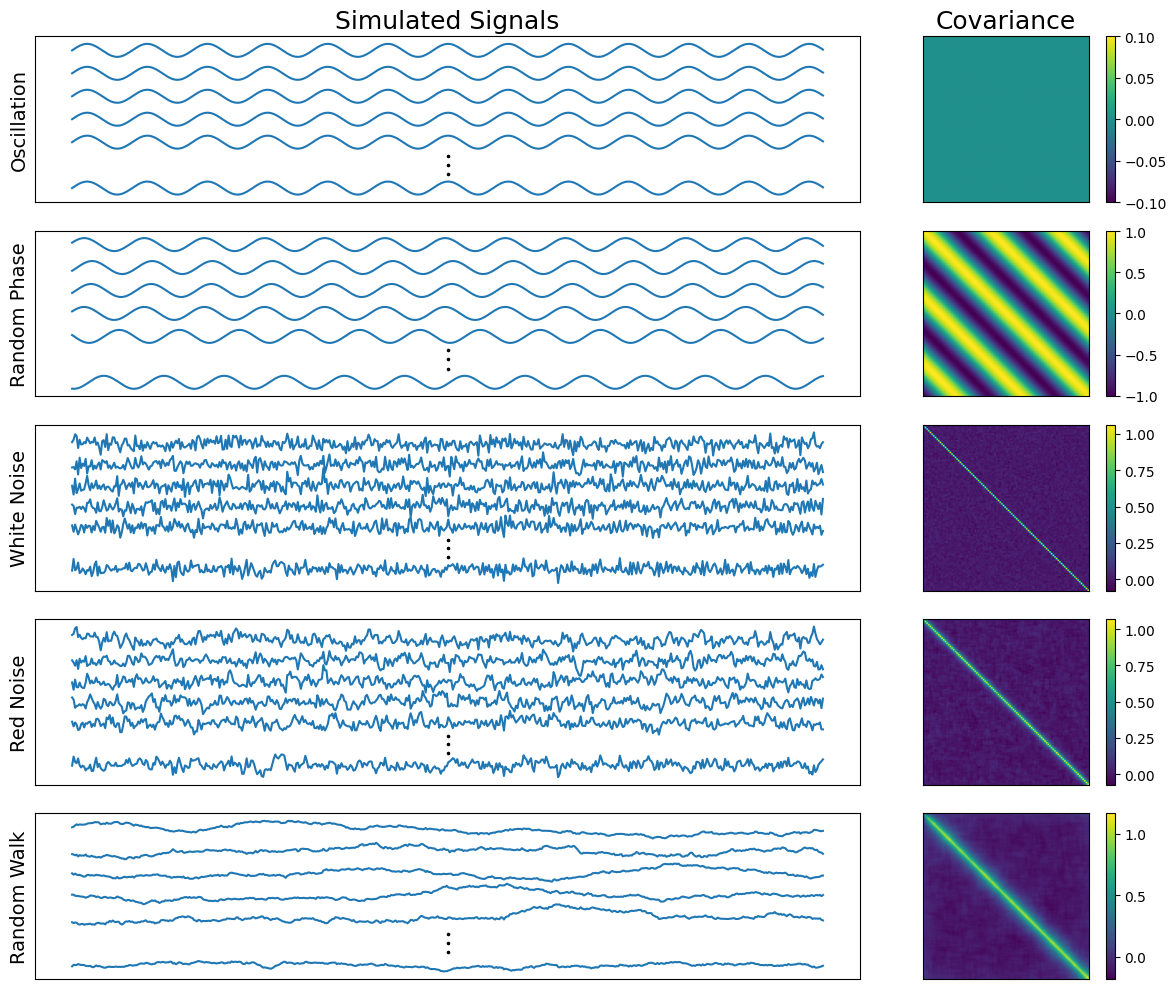

In [4]:
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12 * .8, 8 * .8), width_ratios=[0.75, .25])
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 10),
                         width_ratios=[0.7, .3])
            
plot_sim(X0, axes[0, 0])
plot_cov(cov0.round(6)[:100, :100], axes[0, 1])

plot_sim(X1, axes[1, 0])
plot_cov(cov1[:100, :100], axes[1, 1])

plot_sim(X2, axes[2, 0])
plot_cov(cov2[:100, :100], axes[2, 1])

plot_sim(X3, axes[3, 0])
plot_cov(cov3[:100, :100], axes[3, 1])

plot_sim(X4, axes[4, 0])
plot_cov(cov4, axes[4, 1])

axes[0, 0].set_title("Simulated Signals", size=18)
axes[0, 1].set_title("Covariance", size=18)
axes[0, 0].set_ylabel("Oscillation", size=14)
axes[1, 0].set_ylabel("Random Phase", size=14)
axes[2, 0].set_ylabel("White Noise", size=14)
axes[3, 0].set_ylabel("Red Noise", size=14)
axes[4, 0].set_ylabel("Random Walk", size=14)

plt.tight_layout()
plt.savefig("fig_0_sims.svg")

## 2. Circulant Matrices

- Circulant matrices are diagonalizable by a discrete Fourier transform.
- Eigenvectors (PCs, $\mathbf{Q}$) will be Fourier modes (sinusoids).
- Eigenvalues will be Fourier coefficients.
$$
\begin{align*}
\mathbf{\Lambda} &= \mathbf{Q}^{\top}\text{cov}(\mathbf{X}) \mathbf{Q}
\end{align*}
$$

$$
\definecolor{viridis0}{RGB}{88, 65, 94}  % Dark Purple
\definecolor{viridis1}{RGB}{59, 102, 139} % Blue
\definecolor{viridis2}{RGB}{33, 145, 140} % Greenish
\definecolor{viridis3}{RGB}{94, 201, 98}  % Green
\definecolor{viridis4}{RGB}{253, 231, 37} % Yellow
\begin{align*}
\text{cov}(\mathbf{X}) &= \begin{bmatrix}
c_0 & c_1 & c_2 & c_3 & \cdots & c_n \\
c_n & c_0 & c_1 & c_2 & \cdots & c_{n-1} \\
c_{n-1} & c_n & c_0 & c_1 & \cdots & c_{n-2} \\
c_{n-2} & c_{n-1} & c_n & c_0 & \cdots & c_{n-3} \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
c_1 & c_2 & c_3 & c_5 & \cdots & c_0
\end{bmatrix} \\
\text{cov}(\mathbf{X}) &= \begin{bmatrix}
    \cellcolor{viridis0}c_0 & \cellcolor{viridis1}c_1 & \cellcolor{viridis2}c_2 & \cellcolor{viridis3}c_3 & \cellcolor{viridis4}c_4 \\
    \cellcolor{viridis4}c_4 & \cellcolor{viridis0}c_0 & \cellcolor{viridis1}c_1 & \cellcolor{viridis2}c_2 & \cellcolor{viridis3}c_3 \\
    \cellcolor{viridis3}c_3 & \cellcolor{viridis4}c_4 & \cellcolor{viridis0}c_0 & \cellcolor{viridis1}c_1 & \cellcolor{viridis2}c_2 \\
    \cellcolor{viridis2}c_2 & \cellcolor{viridis3}c_3 & \cellcolor{viridis4}c_4 & \cellcolor{viridis0}c_0 & \cellcolor{viridis1}c_1 \\
    \cellcolor{viridis1}c_1 & \cellcolor{viridis2}c_2 & \cellcolor{viridis3}c_3 & \cellcolor{viridis4}c_4 & \cellcolor{viridis0}c_0 \\
\end{bmatrix}
\end{align*}
$$

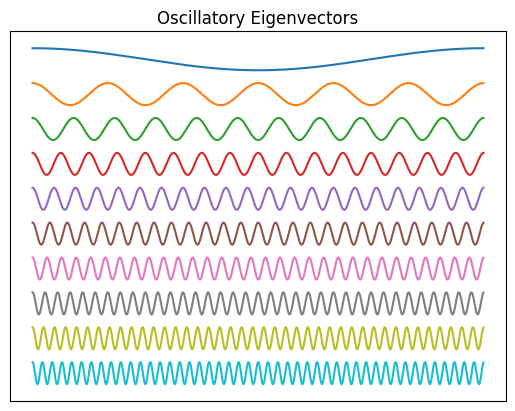

In [5]:
n = 1000
vecs = np.fft.fft(np.eye(n)) / np.sqrt(n)

i = 0
for v in vecs[1:50][::5]:
    plt.plot(v.real + i)
    i -= .1

plt.xticks([])
plt.yticks([])
plt.title("Oscillatory Eigenvectors")
plt.savefig("fig_1_eigvecs.svg");

## 3. Quantification: Kappa
 
- Let the eigenvectors, $\mathbf{Q}$, be Fourier modes.
- Solve for the eigenvalues, $\mathbf{\Lambda}$, which should be diagonal.
- Measure how diagonal $\mathbf{\Lambda}$ is with $\kappa$.

<!-- \kappa &= \frac{\frac{1}{n} \sum_{i} \Lambda_{ii}^2}{
    \frac{1}{n} \sum_{i} \Lambda_{ii}^2
    + \frac{1}{n^2 - n} (\sum_{ij} \Lambda_{ij}^2) - \sum_{i} \Lambda_{ii}^2
} -->

$$
\begin{align*}
\kappa &= \frac{\frac{1}{n}\text{Tr}(\Lambda)}{
    \frac{1}{n} \text{Tr}(\Lambda) +
    \frac{\sum_{ij}\Lambda - \text{Tr}(\Lambda)}{n^2 - n}
} \\
\end{align*}
$$

In [6]:
from matplotlib import colors
from matplotlib import cm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

<!-- $$
\definecolor{v0}{RGB}{88, 65, 94}  % Dark Purple
\definecolor{v1}{RGB}{59, 102, 139} % Blue
\definecolor{v2}{RGB}{33, 145, 140} % Greenish
\definecolor{v3}{RGB}{94, 201, 98}  % Green
\definecolor{v4}{RGB}{253, 231, 37} % Yellow
\begin{bmatrix}
\cellcolor{v0}\quad & \cellcolor{v3}\quad & \cellcolor{v3}\quad & \cellcolor{v3}\quad & \cellcolor{v3}\quad \\
\cellcolor{v3}\quad & \cellcolor{v0}\quad & \cellcolor{v3}\quad & \cellcolor{v3}\quad & \cellcolor{v3}\quad \\
\cellcolor{v3}\quad & \cellcolor{v3}\quad & \cellcolor{v0}\quad & \cellcolor{v3}\quad & \cellcolor{v3}\quad \\
\cellcolor{v3}\quad & \cellcolor{v3}\quad & \cellcolor{v3}\quad & \cellcolor{v0}\quad & \cellcolor{v3}\quad \\
\cellcolor{v3}\quad & \cellcolor{v3}\quad & \cellcolor{v3}\quad & \cellcolor{v3}\quad & \cellcolor{v0}\quad \\
\end{bmatrix}
$$ -->

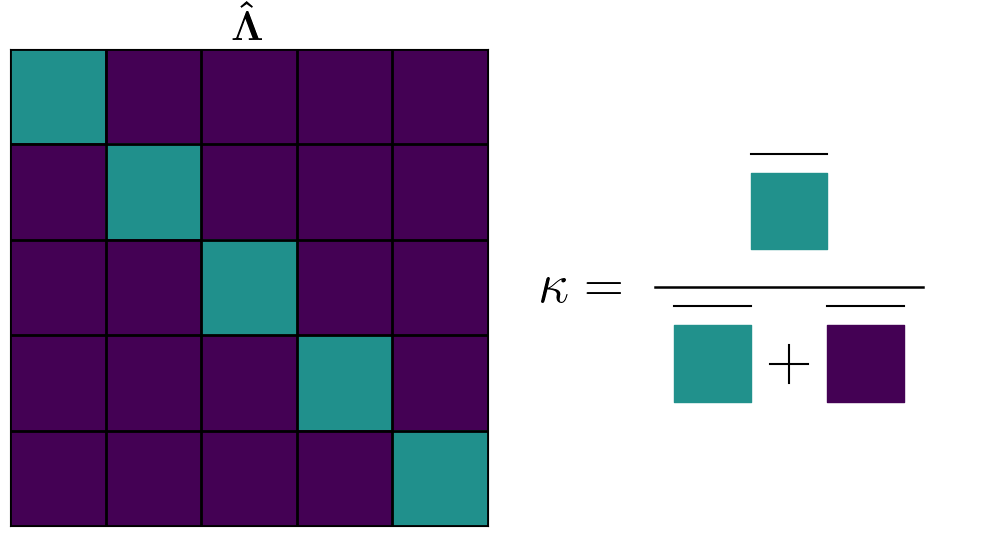

In [8]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=2)

lsq = np.diag(np.ones(5))
axes[0].imshow(lsq, cmap='viridis', vmin=0., vmax=2.)

for i in np.arange(-0.5, 5.5, 1.):
    axes[0].axhline(i, color='k', lw=2)
    axes[0].axvline(i, color='k', lw=2)

axes[0].set_xticks([])
axes[0].set_yticks([]);

norm = colors.Normalize(vmin=0, vmax=2)
smap = cm.ScalarMappable(norm=norm, cmap="viridis")

# Divide
axes[1].plot([0.15, 0.85], [0.5, .5], color='k', lw=1.8)

# Blue
ix = .05
axes[1].fill_between([0.2, 0.4], 0.2, 0.4, color=smap.to_rgba(1.))
axes[1].fill_between([0.4, 0.6], 0.6, 0.8, color=smap.to_rgba(1.))

# Plus
axes[1].plot([0.5, 0.5], [0.25, 0.35], color='k', lw=1.5)
axes[1].plot([0.45, 0.55], [0.3, 0.3], color='k', lw=1.5)

# Purple
axes[1].fill_between([0.6, 0.8], 0.2, 0.4, color=smap.to_rgba(0.))

# Bar
axes[1].plot([0.6, 0.8], [.45, .45], color='k', lw=1.5)
axes[1].plot([0.2, 0.4], [.45, .45], color='k', lw=1.5)
axes[1].plot([0.4, 0.6], [.85, .85], color='k', lw=1.5)

# Kappa
axes[1].text(-.15, 0.46, r"$\mathbf{\kappa} =$", size=40)

axes[1].set_xlim(-.25, 1.)
axes[1].set_ylim(0.1, 0.9)
axes[1].axis("off")

axes[0].set_title(r"$\mathbf{\hat{\Lambda}}$", size=30)
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
plt.tight_layout()

plt.savefig("fig_2_kappa.svg")

## 4. Circulant Convergence:

#### Oscillations: Time Locked 

The covariance matrix of time locked activity is a matrix of zero. Thus the eigenvalues must be zero and any orthonormal eigenvectors will satisfy the eigendecomposition, including Fourier modes.

#### Oscillations: Random Phase

The covariance matrix of oscillations with random phase is oscillatory, giving constants along the diagonals, e.g. a circulant matrix. 

#### White Noise

The covariance of a random normal matrix is identity, a circulant matrix.

$$
\begin{align*}
\text{cov}(\mathbf{X}) &= \mathbf{I}
\end{align*}
$$

The eigenvalues will identity and diagonal, $\kappa \to 1$. Any orthonormal $Q$ will satisfy this, including Fourier modes.

$$
\begin{align*}
\mathbf{\Lambda} &= \mathbf{Q}^{\top}\text{cov}(\mathbf{X}) \mathbf{Q} \\
&= \mathbf{Q}^{\top} \mathbf{I} \mathbf{Q} \\
&= \mathbf{Q}^{\top} \mathbf{Q} \\
&= \mathbf{I}
\end{align*}
$$

#### Red Noise

These are timescales like processes. Covariance will decay to zero out outwards from the diagonal. This is also a circulant matrix.

In [2]:
# Simulate
fs = 1000
freq = 10

n_samples = 1
n_rows = 3_000
n_columns = 1_000

X = np.zeros((4, n_samples, n_rows, n_columns))

for isample in tqdm(range(n_samples), total=n_samples):
    
    # Random phase ocsillations
    _X = np.zeros((n_rows, n_columns))
    for i in range(n_rows):
        _X[i] = np.sin(np.linspace(0, 2*np.pi*freq, n_columns) + np.random.uniform(-np.pi, np.pi))
    X[0, isample] = _X

    # White noise
    _X = np.random.randn(n_rows, n_columns)
    X[1, isample] = _X

    # Red noise
    _X = np.zeros((n_rows, n_columns))
    for i in range(n_rows):
        _X[i] = simulate_ar(n_columns / fs, fs, np.array([0.5]))
    X[2, isample] = _X

    # ~ 1/f^2
    _X = np.zeros((n_rows, n_columns))
    for i in range(n_rows):
        _X[i] = simulate_ar(n_columns / fs, fs, np.array([0.9]))
    X[3, isample] = _X

  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# Step across varying number or rows sizes
steps = np.arange(100, 3100, 100)

# Kappa
kappas = np.zeros((4, len(steps)))

for i in range(4):
    for j in tqdm(range(len(steps)), total=len(steps)):
        kappas[i, j] = compute_kappa(X[i, 0, :steps[j]])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

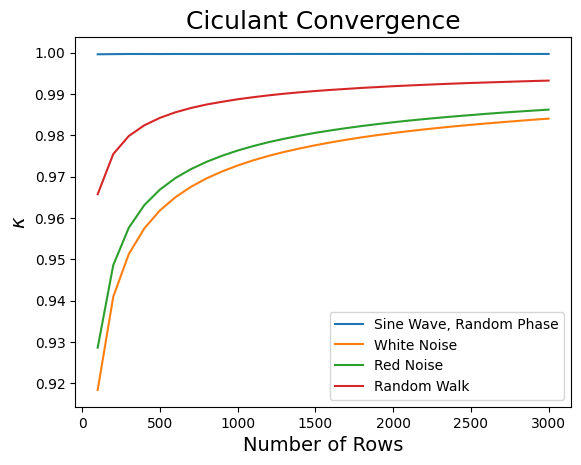

In [6]:
labels = ["Sine Wave, Random Phase", "White Noise", "Red Noise", "Random Walk"]

for i in range(len(kappas)):
    plt.plot(steps, kappas[i], label=labels[i])

plt.legend()
plt.title("Ciculant Convergence", size=18)
plt.xlabel("Number of Rows", size=14)
plt.ylabel(r"$\kappa$", size=14);
plt.savefig("fig_3_circulant_convergence.svg")

## 5. Eigenspectrum & Inversion

- Eigenspectra refers to the eigenvalues of the covariance matrix.
- Eigenspectra are void of time locked activity.
- SVD provides a mechanism to invert the eigenspectra back to the time domain.

In [8]:
# Simulate
fs = 1000
freq = 20

n_rows = 2_000
n_columns = 2_000

X = np.zeros((4, n_rows, n_columns))

# Random phase ocsillations
seed = 0
for i in range(n_rows):
    np.random.seed(seed)
    X[0, i] = np.sin(np.linspace(0, 2*np.pi*freq, n_columns) + np.random.uniform(-np.pi, np.pi))
    X[0, i] = (X[0, i]  - X[0, i].mean()) / X[0, i].std()
    seed += 1
    
# White noise
np.random.seed(seed)
X[1] = np.random.randn(n_rows, n_columns)

# Red noise)
for i in range(n_rows):
    np.random.seed(seed)
    X[2, i] = simulate_ar(n_columns / fs, fs, np.array([0.9]))
    seed += 1

# ~ 1/f^2
for i in range(n_rows):
    np.random.seed(seed)
    X[3, i] = simulate_ar(n_columns / fs, fs, np.array([0.999]))
    seed += 1
    
# Normalize
norm_3d = lambda x : (x - x.mean(axis=1)[:, None, :]) / x.std(axis=1)[:, None, :]
norm_2d = lambda x : (x - x.mean(axis=1)[:, None]) / x.std(axis=1)[:, None]
X = norm_3d(X)

#osc = np.sin(np.linspace(0, 2*np.pi*freq, n_columns))
osc = np.sin(np.linspace(0, 2*np.pi*freq*n_columns/fs, n_columns))
osc = (osc - osc.mean()) / osc.std()

In [9]:
def plot_spectrum(X, ax):
    #freqs, powers = compute_eigenspectrum(X, fs, return_neg=False)
    freqs, powers = compute_eigenspectrum(np.cov(X.T), fs)

    for x in X[::50]:
        f, p = compute_spectrum(x, fs, f_range=(1e-6, 1e6), nperseg=2000)
        ax.loglog(f, p, color='k', alpha=0.1)
        
    ax.loglog(freqs[1:], powers[1:]/(n_rows-1), lw=2.5)

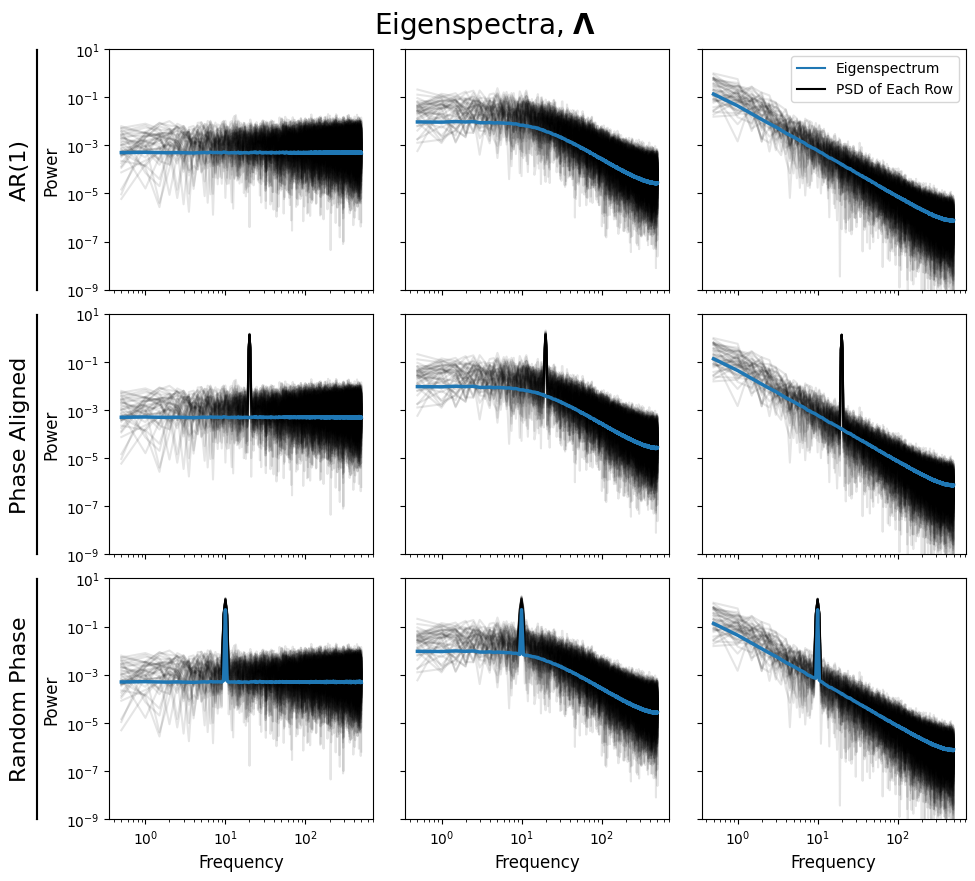

In [17]:
w0 = 0.002
w1 = 0.01
wi = (1-(w0+w1))/3
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 10),
                         width_ratios=[w0, w1, wi, wi, wi])

for i in range(1, len(X)):

    # Stochastic only
    plot_spectrum(X[i], axes[0, i+1])

    # Phase locked oscillation
    X_osc = X[i].copy() + osc
    plot_spectrum(X_osc, axes[1, i+1])

    # Random phase oscillation
    X_osc = X[i].copy() + X[0]
    plot_spectrum(X_osc, axes[2, i+1])

for ax in axes[:, 2]:
    ax.set_ylabel("Power", size=12)

for ax in axes[-1, 2:]:
    ax.set_xlabel("Frequency", size=12)

for i in range(3):
    axf = axes[i, 2:].flatten()
    for ax in axf:
        ax.set_ylim(ymin=1e-9, ymax=1e1)
    for ax in axf[1:]:
        ax.set_yticklabels([])

for i in range(2):
    for j in range(2, 5):
        axes[i, j].set_xticklabels([])
        
axes[0, 0].set_ylabel("AR(1)", size=16)
axes[1, 0].set_ylabel("Phase Aligned", size=16)
axes[2, 0].set_ylabel("Random Phase", size=16)

axes[0, -1].plot([], [], color="C0", label='Eigenspectrum')
axes[0, -1].plot([], [], color="k", label='PSD of Each Row')
axes[0, -1].legend()
plt.suptitle("Eigenspectra, $\mathbf{\Lambda}$", fontsize=20, y=0.92)

for ax in axes[:, 1]:
    ax.axis("off")

for ax in axes[:, 0]:
    ax.axvline(0, color='k')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.fill_between(np.linspace(-1, 1, 10), -2, 2, color='k')
    ax.set_ylim(-1, 1)

fig.subplots_adjust(hspace=0.1)
plt.savefig("fig_4_eigenspectra.svg")

In [11]:
def invert_eig(X, vals, vecs):
    """Invert eigendecomposition back to the time domain."""
    
    # SVD
    S = np.diag(np.sqrt(np.diag(vals)))
    V = vecs
    
    # Left singular vectors
    U = X @ V
    for i in range(U.shape[1]):
        U[:, i] = U[:, i] / np.linalg.norm(U[:, i])

    # Reconstruct signals
    X_re = (U @ S @ V.conj().T).real
    X_re = X_re * np.sqrt(len(X))

    return X_re

def update_vals(cov, vals_fit):
    """Update eigenvalues."""
    # 2d fft
    coefs = np.fft.fft2(cov, norm="ortho")
    
    # fft -> eigenvalues
    #   eigvals of cov == power
    vals = np.diag(np.roll(coefs.real[:, ::-1], 1))
    vals = vals.copy()
    vals[0] = np.sum(cov) / len(cov)

    # Update eigenvalues
    n = int(np.ceil(len(cov)/2))
    vals = vals.copy()
    vals[1:n] = vals_fit
    vals[n+1:] = vals_fit[::-1]
    
    return vals

In [12]:
_X_osc = np.zeros_like(X[2])
n = len(_X_osc)


phases = np.random.uniform(0, 1, n)
phases[0] = 1.
phases[1] = 0.
phases[2] = 0.75
phases[3] = 0.25
phases[4] = 0.5


for i in range(n):
    _X_osc[i] = sim_oscillation(n/fs, fs, 20, cycle='asine', rdsym=0.8, phase=phases[i]) * 2

# Phase locked oscillation
X_osc_rand = X[2].copy() + _X_osc

# Random phase oscillation
X_osc = X[2].copy() + _X_osc[0]

In [13]:
from timescales.autoreg.fit import ARPSD
from eigvec.circulant import compute_eig

# Phase locked
vals, vecs = compute_eig(np.cov(X_osc.T))
X_re = invert_eig(X_osc, vals, vecs)

# Random phase
vals_rand, vecs_rand = compute_eig(np.cov(X_osc_rand.T))
X_re_rand = invert_eig(X_osc_rand, vals_rand, vecs_rand)

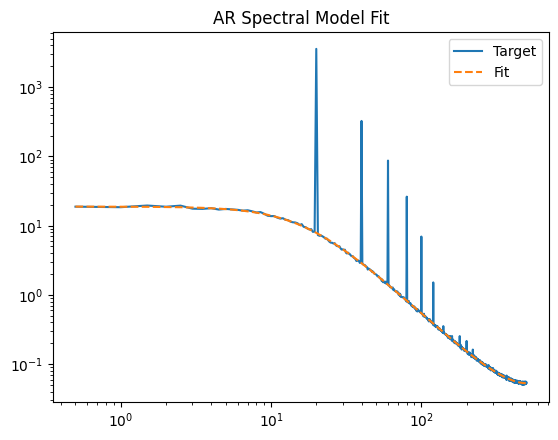

In [14]:
# Fit eigenspectrum
cov = np.cov(X_osc_rand.T)
freqs, powers = compute_eigenspectrum(cov, fs)
freqs, powers = freqs[1:], powers[1:]

model = ARPSD(1, fs, ar_bounds=(0, 1), loss_fn='huber', f_scale=.01)
model.fit(freqs, powers)
vals_fit = model.powers_fit
model.plot()

# Invert
vals_new = update_vals(cov, vals_fit)
X_re_rand_ap = invert_eig(X_osc_rand, np.diag(vals_new), vecs_rand)

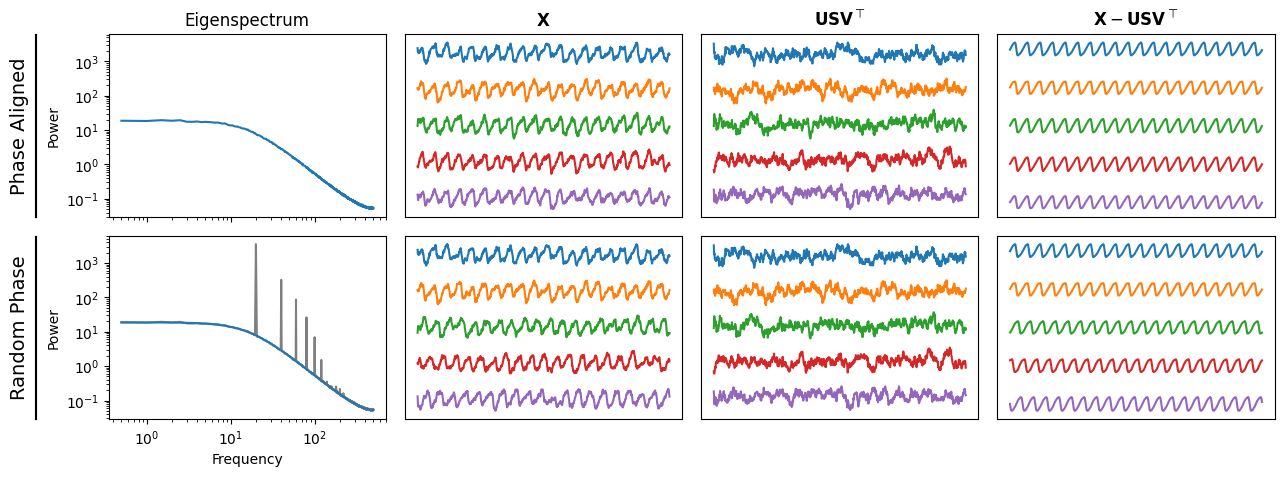

In [14]:
# Plot
inds = [0, 1, 2, 3, 4]

r0 = 0.0015
r1 = 0.03
w = (1-r0-r1) / 4
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(16, 5),
                         sharey="col", sharex="col", width_ratios=[r0, r1, w, w, w, w])
fig.subplots_adjust(hspace=0.1, wspace=0.1)

freqs, powers = compute_eigenspectrum(np.cov(X_osc.T), fs)
axes[0, 2].loglog(freqs[1:], powers[1:])

freqs, powers = compute_eigenspectrum(np.cov(X_osc_rand.T), fs)
axes[1, 2].loglog(freqs[1:], powers[1:], color="k", alpha=.5)
axes[1, 2].loglog(freqs[1:], model.powers_fit, color="C0")

for i in range(5):
    
    ax = axes[0]
    ax[3].plot(X_osc[inds[i]][:1000] - i * 8 * 2)
    ax[4].plot(X_re[inds[i]][:1000] - i * 8)
    ax[5].plot(X_osc[inds[i]][:1000]-X_re[inds[i]][:1000] - i * 8 * 2)
    
    ax = axes[1]
    ax[3].plot(X_osc_rand[inds[i]][:1000] - i * 8 * 2)
    ax[4].plot(X_re_rand_ap[inds[i]][:1000] - i * 8)
    ax[5].plot(X_osc_rand[inds[i]][:1000]-X_re_rand_ap[inds[i]][:1000] - i * 8 * 2)

for i in range(2):
    for j in range(3, 6):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

axes[0, 2].set_title("Eigenspectrum")
axes[0, 3].set_title(r"$\mathbf{X}$")
axes[0, 4].set_title(r"$\mathbf{U} \mathbf{S} \mathbf{V}^{\top}$")
axes[0, 5].set_title(r"$\mathbf{X} - \mathbf{U} \mathbf{S} \mathbf{V}^{\top}$")

for ax in axes[:, 1]:
    ax.axis("off")
    
for ax in axes[:, 0]:
    ax.set_yticks([])
    ax.set_xticks([])

axes[0, 2].set_ylabel("Power")
axes[1, 2].set_ylabel("Power")
axes[1, 2].set_xlabel("Frequency")
axes[0, 0].set_facecolor("k")
axes[1, 0].set_facecolor("k")
axes[0, 0].set_ylabel("Phase Aligned", size=14)
axes[1, 0].set_ylabel("Random Phase", size=14)
plt.savefig("fig_5_inversion.svg")

In [18]:
283.2/8

35.4